# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import datetime
import json
import os
import time

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import numpy as np
import pandas as pd
from plotnine import *

from utils import fill_spec_with_data, get_model_coefficients, get_genes_coefficients

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

## Specify model configuration

In [3]:
# We're going to be building a classifier with multiple genes filtered by two diseases 
# Example:
# gene_ids = ['7157', '7158', '7159', '7161']

# Information passed into the notebook is stored in environment variables
gene_ids = os.environ.get('gene_ids')
if not gene_ids:
    gene_ids = ['7157'] # TP53 is the default
else:
    gene_ids = gene_ids.split('-')
    
disease_acronyms = os.environ.get('disease_acronyms')

if not disease_acronyms:
    disease_acronyms = [] # use all of the diseases as default
    # disease_acronyms = ['LUAD', 'BLCA']
else:
    disease_acronyms = disease_acronyms.split('-')
    
print("Genes: " + str(gene_ids))
print("Diseases: " + str(disease_acronyms))

Genes: ['7157']
Diseases: []


*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
path = os.path.join('download', 'expression-matrix.tsv.bz2')
expression_df = pd.read_table(path, index_col=0)

path = os.path.join('download', 'mutation-matrix.tsv.bz2')
mutation_df = pd.read_table(path, index_col=0)

path = os.path.join('download', 'covariates.tsv')
covariate_df = pd.read_table(path, index_col=0)

In [5]:
# Select acronym_x and n_mutations_log1p covariates only
disease_cols = [col for col in covariate_df.columns if col.startswith('acronym_')]

# Filter covariate columns by disease if a list was provided
if disease_acronyms:
    disease_cols = [col for col in disease_cols if col.endswith(tuple(disease_acronyms))]
    
selected_cols = disease_cols + ['n_mutations_log1p']
covariate_df = covariate_df[selected_cols]

In [6]:
%%time
path = os.path.join('download', 'expression-genes.tsv')
expression_genes_df = pd.read_table(path, index_col=0)

CPU times: user 30 ms, sys: 10 ms, total: 40 ms
Wall time: 36.9 ms


In [7]:
# Filter the rows by disease type
# subsection of columns with row-wise max
has_disease = covariate_df[disease_cols].max(axis=1) > 0
covariate_df = covariate_df[has_disease]

In [8]:
# filter by sample_id
expression_df = expression_df[expression_df.index.isin(covariate_df.index)]

# filter by sample_id
mutation_df = mutation_df[mutation_df.index.isin(covariate_df.index)]

In [9]:
# The series holds Gene Mutation Status for each sample
# Take max of mutation status, meaning if any of the genes mutated the value should be 1
y = mutation_df[gene_ids].max(axis=1)
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
dtype: int64

In [10]:
print('Gene expression matrix shape: {}'.format(expression_df.shape))
print('Covariates matrix shape: {}'.format(covariate_df.shape))

Gene expression matrix shape: (7306, 20468)
Covariates matrix shape: (7306, 33)


## Set aside 10% of the data for testing

In [11]:
# Typically, this type of split can only be done 
# for genes where the number of mutations is large enough
X = pd.concat([covariate_df, expression_df], axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Here are the percentage of tumors with TP53
y.value_counts(True)

0    0.645907
1    0.354093
dtype: float64

## Feature selection

In [12]:
def select_feature_set_columns(X, feature_set):
    """
    Select the feature set for the different models within the pipeline
    """
    n_covariates = len(covariate_df.columns)
    if feature_set == 'covariates':
        return X[:, :n_covariates]
    if feature_set == 'expressions':
        return X[:, n_covariates:]
    raise ValueError('feature_set not supported: {}'.format(feature_set))

# Creates the expression features by standarizing them and running PCA
# Because the expressions matrix is so large, we preprocess with PCA
# The amount of variance in the data captured by ~100 components is high
expression_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'expressions'})),
    ('standardize', StandardScaler()),
    ('pca', PCA())
])

# Creates the covariate features by selecting and standardizing them
covariate_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'covariates'})),
    ('standardize', StandardScaler())
])

## Elastic net classifier and model paraemeters

In [13]:
# Parameter Sweep for Hyperparameters
n_components_list = [50, 100]
regularization_alpha_list = [10 ** x for x in range(-3, 1)]
regularization_l1_ratio = 0.15

param_grids = {
    'full': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'expressions': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'covariates': {
        'classify__alpha': regularization_alpha_list
    }
}

# Classifier: Elastic Net
classifier = SGDClassifier(penalty='elasticnet',
                           l1_ratio=regularization_l1_ratio,
                           loss='log', 
                           class_weight='balanced',
                           random_state=0)

## Define pipeline and cross validation

In [14]:
# Full model pipelines
pipeline_definitions = {
    'full': Pipeline([
        ('features', FeatureUnion([
            ('expressions', expression_features),
            ('covariates', covariate_features)
        ])),
        ('classify', classifier)
    ]),
    'expressions': Pipeline([
        ('features', FeatureUnion([('expressions', expression_features)])),
        ('classify', classifier)
    ]),
    'covariates': Pipeline([
        ('features', FeatureUnion([('covariates', covariate_features)])),
        ('classify', classifier)
    ])
}

# Construct cross-validated grid searches
cv_pipelines = dict()
for model, pipeline in pipeline_definitions.items():
    cv = StratifiedKFold(n_splits=3, random_state=0)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model],
        cv=cv,
        n_jobs=1, 
        scoring='roc_auc',
    )
    cv_pipelines[model] = grid_search

In [15]:
# Fit the models
for model, pipeline in cv_pipelines.items():
    print('Fitting CV for model: {0}'.format(model))
    start_time = time.perf_counter()
    pipeline.fit(X=X_train, y=y_train)
    end_time = time.perf_counter()
    elapsed = datetime.timedelta(seconds=end_time - start_time)
    print('\truntime: {}'.format(elapsed))

Fitting CV for model: full
	runtime: 0:01:47.540831
Fitting CV for model: expressions
	runtime: 0:01:41.536905
Fitting CV for model: covariates
	runtime: 0:00:08.529364


In [16]:
# Best Parameters
for model, pipeline in cv_pipelines.items():
    print('#', model)
    print(pipeline.best_params_)
    print('cv_auroc = {:.3%}'.format(pipeline.best_score_))

# full
{'classify__alpha': 1, 'features__expressions__pca__n_components': 50}
cv_auroc = 87.885%
# expressions
{'classify__alpha': 1, 'features__expressions__pca__n_components': 100}
cv_auroc = 87.842%
# covariates
{'classify__alpha': 0.01}
cv_auroc = 84.206%


## Visualize hyperparameters performance

In [17]:
cv_results_df = pd.DataFrame()
for model, pipeline in cv_pipelines.items():
    df = pd.concat([
        pd.DataFrame(pipeline.cv_results_),
        pd.DataFrame.from_records(pipeline.cv_results_['params'])
    ], axis='columns')
    df['feature_set'] = model
    cv_results_df = cv_results_df.append(df)

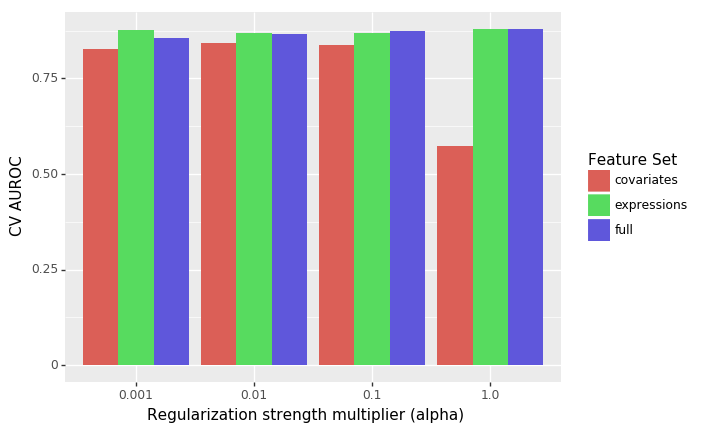

<ggplot: (8762023816526)>

In [18]:
# Cross-validated performance heatmap
cv_results_df['classify__alpha'] = cv_results_df['classify__alpha'].astype(str)

(ggplot(cv_results_df, aes(x='classify__alpha',
                           y='mean_test_score',
                           fill='feature_set'))
 + geom_bar(stat='identity', position='dodge')
 + labs(x='Regularization strength multiplier (alpha)',
        y='CV AUROC')
 + guides(fill=guide_legend(title="Feature Set"))
)

## Use optimal hyperparameters to output ROC curve

In [19]:
y_pred_dict = {
    model: {
        'train': pipeline.decision_function(X_train),
        'test':  pipeline.decision_function(X_test)
    } for model, pipeline in cv_pipelines.items()
}

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_dict = {    
    model: {
        'train': get_threshold_metrics(y_train, y_pred_dict[model]['train']),
        'test':  get_threshold_metrics(y_test, y_pred_dict[model]['test'])
    } for model in y_pred_dict.keys()
}

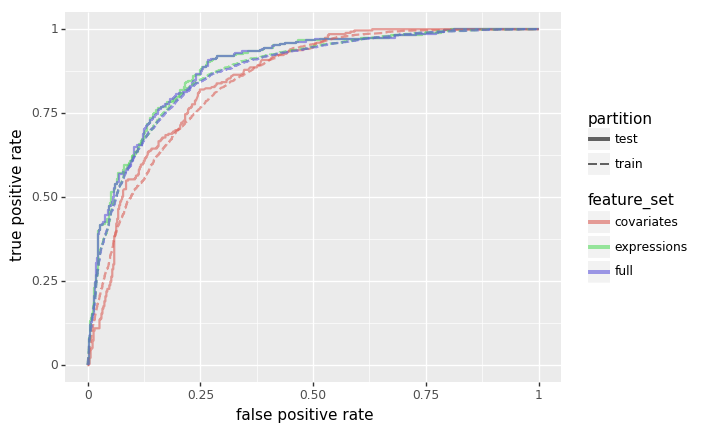

<ggplot: (8762019253838)>

In [20]:
# Assemble the data for ROC curves
model_order = ['full', 'expressions', 'covariates']

auc_output = pd.DataFrame()
roc_output = pd.DataFrame()

for model in model_order:
    metrics_partition = metrics_dict[model]
    for partition, metrics in metrics_partition.items():
        auc_output = auc_output.append(pd.DataFrame({
            'partition': [partition],
            'feature_set': [model],
            'auc': metrics['auroc'].round(3)
        }))
        roc_df = metrics['roc_df']
        roc_output = roc_output.append(pd.DataFrame({
            'false_positive_rate': roc_df.fpr,
            'true_positive_rate': roc_df.tpr,
            'partition': partition,
            'feature_set': model
        }))

(ggplot(roc_output, aes(x='false_positive_rate',
                        y='true_positive_rate',
                        color='feature_set',
                        linetype='partition'))
 + geom_line(size=0.9, alpha=0.6)
 + labs(x='false positive rate', y='true positive rate')
)

### AUROC

In [21]:
pd.pivot_table(auc_output,
               values='auc',
               index='partition',
               columns='feature_set')

feature_set,covariates,expressions,full
partition,,,
test,0.851,0.887,0.886
train,0.844,0.873,0.871


## What are the classifier coefficients?

In [22]:
final_pipelines = {
    model: pipeline.best_estimator_
    for model, pipeline in cv_pipelines.items()
}
final_classifiers = {
    model: pipeline.named_steps['classify']
    for model, pipeline in final_pipelines.items()
}

coef_df = pd.concat([
    get_model_coefficients(classifier, model, covariate_df.columns)
    for model, classifier in final_classifiers.items()
])

In [23]:
# Signs of the coefficients by model
pd.crosstab(coef_df.feature_set, np.sign(coef_df.weight).rename('coefficient_sign'))

coefficient_sign,-1.0,0.0,1.0
feature_set,,,
covariates,15,5,13
expressions,14,74,12
full,13,61,9


### Top coefficients for covariates model

In [24]:
coef_df.query("feature_set == 'full'").head(10)

,feature,weight,abs,feature_set
8,PCA_8,-0.037163,0.037163,full
29,PCA_29,-0.035561,0.035561,full
2,PCA_2,-0.035350,0.035350,full
24,PCA_24,0.032837,0.032837,full
11,PCA_11,-0.032826,0.032826,full
22,PCA_22,-0.030797,0.030797,full
37,PCA_37,0.029241,0.029241,full
1,PCA_1,-0.028202,0.028202,full
17,PCA_17,0.025102,0.025102,full
34,PCA_34,-0.023984,0.023984,full


### Top coefficients for individual _genes_ for full model

In [25]:
pca_for_full = (
    final_pipelines['full']
    .named_steps['features']
    .get_params()['expressions__pca']
    )
classifier_for_full = (
    final_pipelines['full']
    .named_steps['classify']
    )
gene_coefficients_for_full = get_genes_coefficients(
    pca_object=pca_for_full,
    classifier_object=classifier_for_full,
    expression_df=expression_df,
    expression_genes_df=expression_genes_df,
    num_covariates=len(covariate_df.columns)
    )
gene_coefficients_for_full.head(10)

,symbol,weight,abs,description
entrez_id,,,,
1643,DDB2,-0.003410,0.003410,damage specific DNA binding protein 2
8767,RIPK2,0.003273,0.003273,receptor interacting serine/threonine kinase 2
25879,DCAF13,0.003267,0.003267,DDB1 and CUL4 associated factor 13
3654,IRAK1,0.003168,0.003168,interleukin 1 receptor associated kinase 1
79581,SLC52A2,0.003081,0.003081,solute carrier family 52 member 2
114907,FBXO32,0.003079,0.003079,F-box protein 32
157378,TMEM65,0.003040,0.003040,transmembrane protein 65
6788,STK3,0.003019,0.003019,serine/threonine kinase 3
734,OSGIN2,0.003019,0.003019,oxidative stress induced growth inhibitor fami...


### Top coefficients for individual _genes_ for expressions model

In [26]:
pca_for_expression = (
    final_pipelines['expressions']
    .named_steps['features']
    .get_params()['expressions__pca']
    )
classifier_for_expression = (
    final_pipelines['expressions']
    .named_steps['classify']
    )
gene_coefficients_for_expression = get_genes_coefficients(
    pca_object=pca_for_expression,
    classifier_object=classifier_for_expression,
    expression_df=expression_df,
    expression_genes_df=expression_genes_df
    )
gene_coefficients_for_expression.head(10)

,symbol,weight,abs,description
entrez_id,,,,
1643,DDB2,-0.003589,0.003589,damage specific DNA binding protein 2
8767,RIPK2,0.003493,0.003493,receptor interacting serine/threonine kinase 2
734,OSGIN2,0.003255,0.003255,oxidative stress induced growth inhibitor fami...
157378,TMEM65,0.003247,0.003247,transmembrane protein 65
25879,DCAF13,0.003237,0.003237,DDB1 and CUL4 associated factor 13
3654,IRAK1,0.003213,0.003213,interleukin 1 receptor associated kinase 1
6788,STK3,0.003139,0.003139,serine/threonine kinase 3
8704,B4GALT2,0.003108,0.003108,"beta-1,4-galactosyltransferase 2"
60401,EDA2R,-0.003098,0.003098,ectodysplasin A2 receptor


## Investigate the predictions

In [27]:
predict_df = pd.DataFrame()
for model, pipeline in final_pipelines.items():
    df = pd.DataFrame.from_items([
        ('feature_set', model),
        ('sample_id', X.index),
        ('test_set', X.index.isin(X_test.index).astype(int)),
        ('status', y),
        ('decision_function', pipeline.decision_function(X)),
        ('probability', pipeline.predict_proba(X)[:, 1])
    ])    
    predict_df = predict_df.append(df)

predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [28]:
# Top predictions amongst negatives (potential hidden responders to a targeted cancer therapy)
(predict_df
    .sort_values('decision_function', ascending=False)
    .query("status == 0 and feature_set == 'full'")
    .head(10)
)

,feature_set,sample_id,test_set,status,decision_function,probability,probability_str
sample_id,,,,,,,
TCGA-L5-A4OH-01,full,TCGA-L5-A4OH-01,0,0,4.009367,0.982178,98.2%
TCGA-L5-A8NR-01,full,TCGA-L5-A8NR-01,0,0,3.835590,0.978868,97.9%
TCGA-EI-6513-01,full,TCGA-EI-6513-01,1,0,3.554463,0.972198,97.2%
TCGA-E2-A1LI-01,full,TCGA-E2-A1LI-01,0,0,3.449171,0.969206,96.9%
TCGA-HF-7136-01,full,TCGA-HF-7136-01,0,0,3.384553,0.967218,96.7%
TCGA-21-1081-01,full,TCGA-21-1081-01,0,0,3.303104,0.964535,96.5%
TCGA-L5-A4OS-01,full,TCGA-L5-A4OS-01,0,0,3.261185,0.963073,96.3%
TCGA-B6-A0I1-01,full,TCGA-B6-A0I1-01,0,0,3.196801,0.960714,96.1%
TCGA-E9-A3QA-01,full,TCGA-E9-A3QA-01,0,0,3.178608,0.960021,96.0%


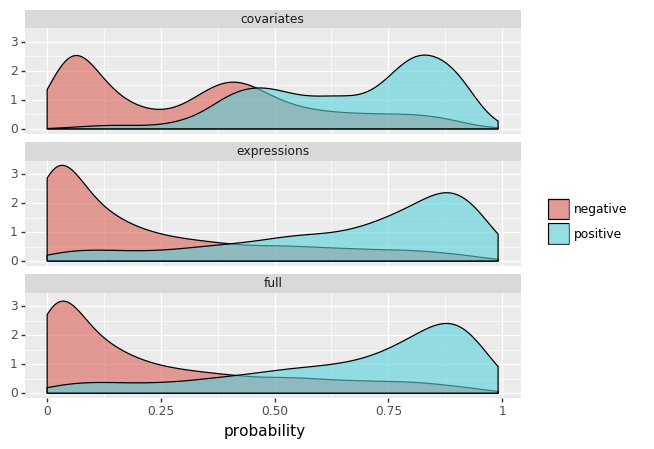

<ggplot: (-9223363274835408198)>

In [29]:
predict_df['status_'] = predict_df['status'].map(
    lambda x: 'negative' if x == 0 else 'positive')

(ggplot(predict_df, aes(x='probability', fill='status_'))
 + geom_density(alpha=0.6)
 + facet_wrap('~feature_set', ncol=1)
 + labs(x='probability', y='')
 + guides(fill=guide_legend(title="")))